Start with a picture and create a colorcoded picture

all bicycle picture of the same color. road line of same color. tree same color

Each of the objects -- buildings, roads, trees--  have same number (colors)

Classification problems for objects and the corresponding pixels

This is called segmentation


Segmentation data set -- download a dataset where someoen had labelled every pixel -- very common in medical applications, self driving cars



In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [3]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/home/jupyter/.fastai/data/camvid/valid.txt'),
 PosixPath('/home/jupyter/.fastai/data/camvid/labels'),
 PosixPath('/home/jupyter/.fastai/data/camvid/images'),
 PosixPath('/home/jupyter/.fastai/data/camvid/codes.txt')]

details of the datasets:
    
https://course.fast.ai/datasets    

In [4]:
path_lbl = path/'labels'
path_img = path/'images'

## Data

In [5]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/home/jupyter/.fastai/data/camvid/images/0016E5_08190.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/images/Seq05VD_f02610.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/images/Seq05VD_f04980.png')]

In [6]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/home/jupyter/.fastai/data/camvid/labels/0016E5_01170_P.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/labels/Seq05VD_f03960_P.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/labels/0006R0_f02100_P.png')]

coded filenames for images and segment masks

In the above filenames -- Segment masks has an extension of _P 

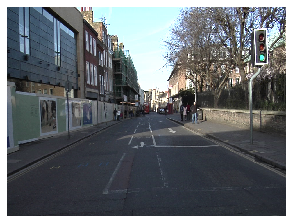

In [7]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In the above filenames -- Segment masks has an extension of _P 

A function is taken to remove _P from the filename and put it in a different location

In [8]:
get_y_fn = lambda x : path_lbl/f'{x.stem}_P{x.suffix}'

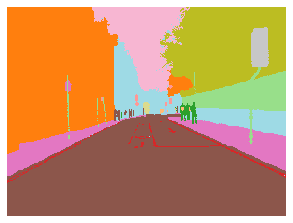

In [9]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

It openend the file -- so the labels match

Usually, we use open_image to open an image and then do show

Whereas in the case of segment mask, it is not an image. it is array of integers for different categories as mentioned in the first line--- so we use open_mask

fastai -- automatically colorcodes the masks and displays it

In [11]:
src_size = np.array(mask.shape[1:])
src_size

array([720, 960])

In [12]:
mask.data

tensor([[[ 4,  4,  4,  ..., 26, 26, 26],
         [ 4,  4,  4,  ..., 26, 26, 26],
         [ 4,  4,  4,  ..., 26, 26, 26],
         ...,
         [17, 17, 17,  ..., 17, 17, 17],
         [17, 17, 17,  ..., 17, 17, 17],
         [17, 17, 17,  ..., 17, 17, 17]]])

In the data downloaded, we also have codes.txt

It has a list of the categories in the indexes

0 - Animal
1 - Archway

this is the same mask array seen above

In [13]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

## Datasets

In [14]:
size = src_size//2

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=8, have 16270MB of GPU RAM free


In [ ]:
We are using a smaller batch size -- creating a classifier for every pixel can take a lot of GPU

Valid.txt is also given with the download set-- Pictures given are frames of videos.. if we divide randomly and if there are 2 frames next to one another -- one in validation and training set each  -- then it is not a valid training. so we take the given valid.txt which is created with non continuous part of the video

get_y_fn is the lambda function we created above for labels

list of class names -- codes -- in our case each lable is a number and the numbers are matched to the codes with the codes.txt file

so each label is inderctly pointed to an object 

In [15]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In our case, each image corresponds to the lable files

if there is a transformation on x, we need to have same transformation on y -- tfm_y = True

In [16]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

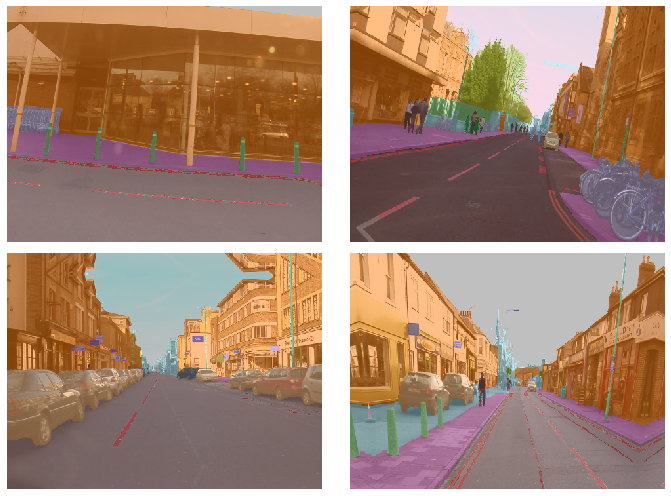

In [17]:
data.show_batch(2, figsize=(10,7))

fastai show_batch for segmentation masks -- colorcodes the photo based on the array

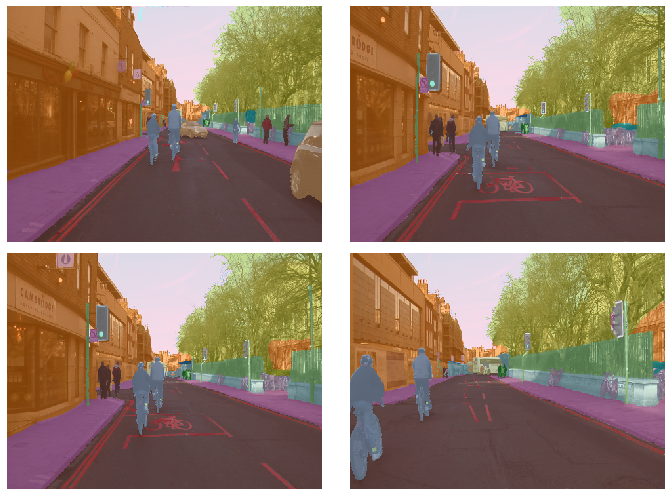

In [18]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

In [20]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

Accuracy for segmentaion tasks -- currently classified pixels / total number of pixels 



We cretaed a new metric called acc_camvid

lables of a few pixels are given as void-- when you are reporting accuracy, you should remove void pixels

input to the metric and the target -- actual label

We create a mask where target is not equal to voide. 

then apply argmax on the inpput  = target  take the mean of it

In [21]:
metrics=acc_camvid


In [22]:
wd=1e-2

For segmentation we use unet architecture  and not cNN.

CNN -- starts with a big image and makes it smaller and smaller till a pixel

unet -- takes the smaller pixel and creates the big image-- this is u shaped image
https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/

In [23]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


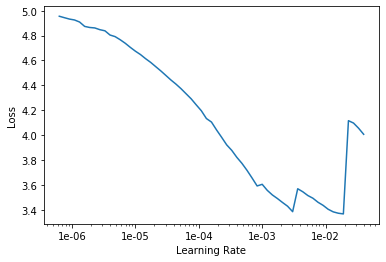

In [24]:
lr_find(learn)
learn.recorder.plot()

In [25]:
lr=3e-3

In [27]:
learn.fit_one_cycle(5, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.914867,0.670253,0.835856,00:52
1,0.747307,0.794820,0.793690,00:49
2,0.760830,0.610739,0.847039,00:49
3,0.698560,0.607529,0.842101,00:49
4,0.692252,0.516899,0.865963,00:49


In [28]:
learn.fit_one_cycle(5, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.524308,0.423049,0.881453,00:49
1,0.510240,0.416079,0.882225,00:48
2,0.520914,0.418187,0.879618,00:49
3,0.519767,0.436427,0.885324,00:49
4,0.505657,0.397288,0.885683,00:49


In [29]:
learn.save('stage-1')

In [30]:
learn.unfreeze()

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


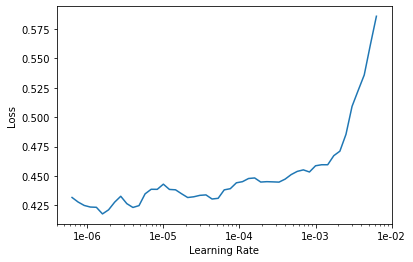

In [31]:
lr_find(learn)
learn.recorder.plot()

In [32]:
lrs = slice(1e-5,lr/5)

In [33]:
learn.fit_one_cycle(5, lrs)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.418441,0.345292,0.894924,00:50
1,0.398523,0.353936,0.900295,00:50
2,0.370929,0.299489,0.915693,00:50
3,0.337296,0.307756,0.910174,00:50
4,0.316815,0.295429,0.915186,00:50


Recorder keeps track of what is going on during training

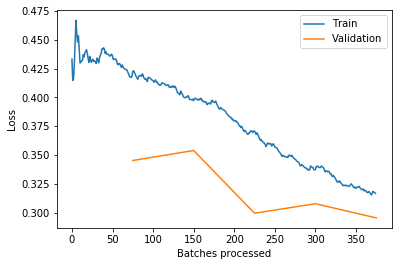

In [34]:
learn.recorder.plot_losses()

Trainirecordeross and validation loss is plotted,  most often, they go up a bit before they go down

This is also same in the learning rate


because fit_one_cycle-- starts lr go from low to high to low

Getting the right lr is very important -- not too high or low-- as we get close to the right spot, we want the lr to decrease in terms of the steps-- check the video image at 1:22

This idea is called learning rate annealing

Gradually increaseing the lr at video 1:23-- we need to find a global minima rather than a local minima more flat surface

gradually increasing-- results in exploring the entire loss function surface and find areas where loss is low and not a bumpy surface

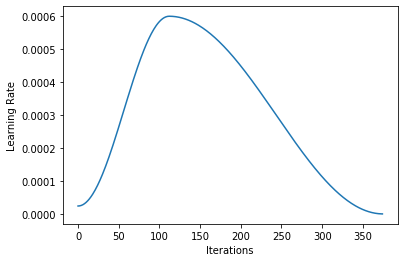

In [35]:
learn.recorder.plot_lr()

When we call fit_one_cycle -- we are passing a maximum lr in the above plot.

If the plot of losses (recorder.plot_losses()) is always going down, we can increase the lr a little bit


In [36]:
learn.save('stage-2');

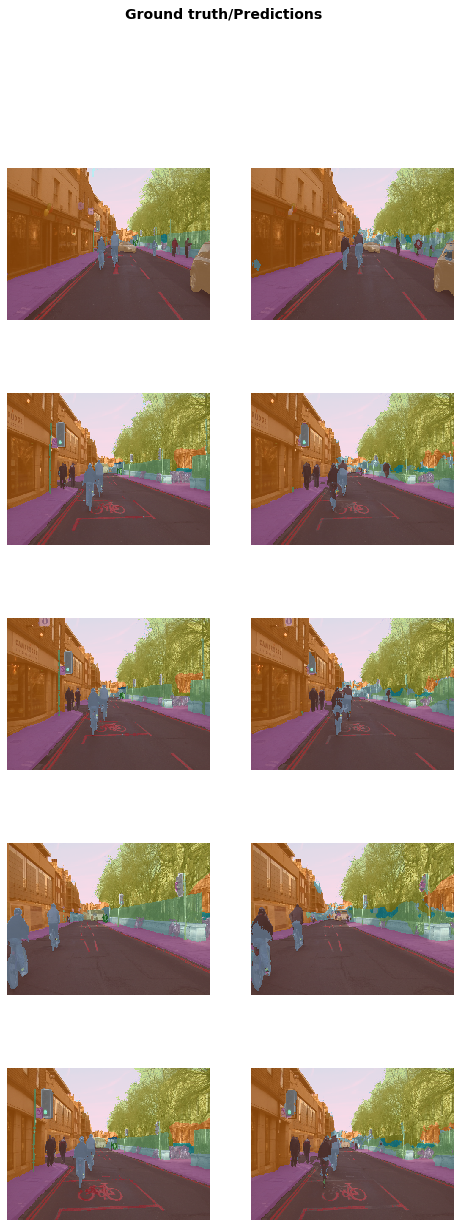

In [37]:
learn.show_results()

## Use full size 

When we have given the original data set we have taken size = src_size//2 -- 

Now we increase the full size

But with bs = bs//2

We use the same learner as prev, but with different data

Repeat the cycle

If we are running out of memory with mixed precision floating -- instead of 32 bits we can use 16 bits of the memory

End of any learner call learner.create_unet().to_fp16()
add to_fp16()

Sometimes we might even get a better accuracy